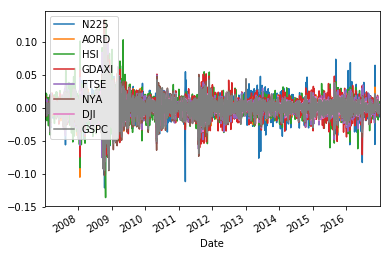

Epoch 	 loss
3000 	 0.615521
6000 	 0.614909
9000 	 0.592168
12000 	 0.613718
15000 	 0.589275
18000 	 0.598751
21000 	 0.595098
24000 	 0.580208
27000 	 0.580678
30000 	 0.592112


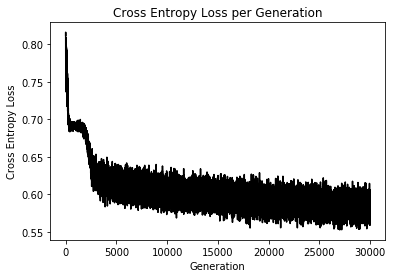

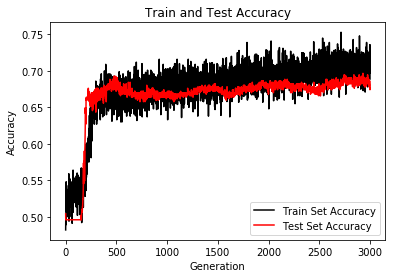

Up_Accuracy	= 0.673554
Down_Accuracy	= 0.678862
Accuracy	= 0.67623


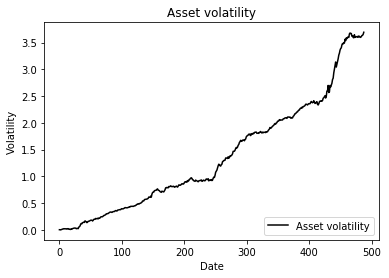

Epoch 	 loss
3000 	 0.614176
6000 	 0.639202
9000 	 0.605093
12000 	 0.62875
15000 	 0.597733
18000 	 0.599221
21000 	 0.599012
24000 	 0.594869
27000 	 0.609409
30000 	 0.599379


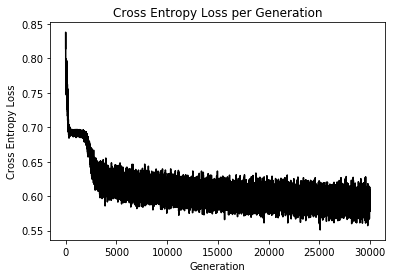

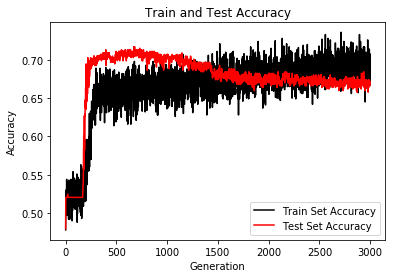

Up_Accuracy	= 0.641732
Down_Accuracy	= 0.705128
Accuracy	= 0.672131


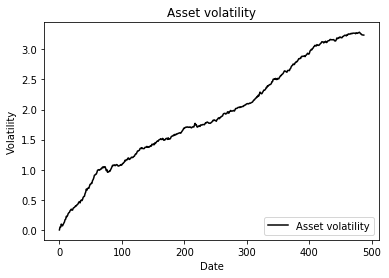

Epoch 	 loss
3000 	 0.620239
6000 	 0.624235
9000 	 0.595961
12000 	 0.610992
15000 	 0.597987
18000 	 0.583525
21000 	 0.59642
24000 	 0.590024
27000 	 0.602477
30000 	 0.601856


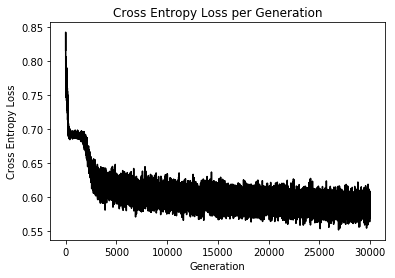

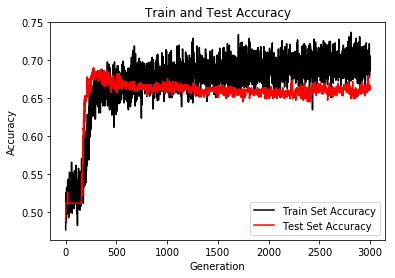

Up_Accuracy	= 0.704
Down_Accuracy	= 0.617647
Accuracy	= 0.661885


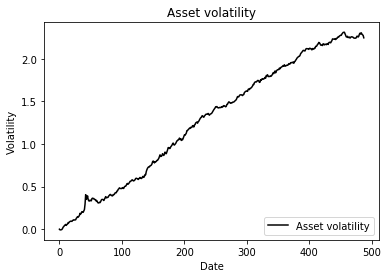

Epoch 	 loss
3000 	 0.626845
6000 	 0.634254
9000 	 0.598285
12000 	 0.620263
15000 	 0.597844
18000 	 0.572378
21000 	 0.586004
24000 	 0.592568
27000 	 0.588854
30000 	 0.588024


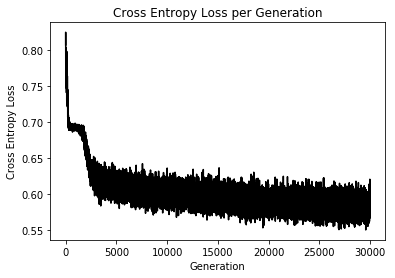

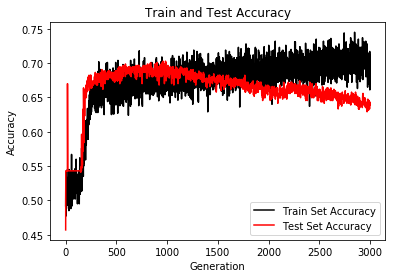

Up_Accuracy	= 0.671698
Down_Accuracy	= 0.600897
Accuracy	= 0.639344


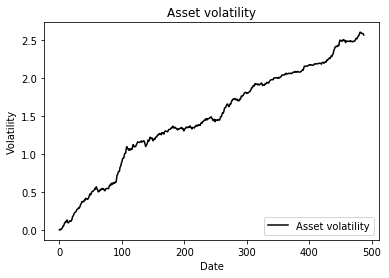

Epoch 	 loss
3000 	 0.616348
6000 	 0.617041
9000 	 0.604712
12000 	 0.593327
15000 	 0.594883
18000 	 0.568596
21000 	 0.589877
24000 	 0.572599


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from model import Model

# ダウンロードしてきたやつ
INDEIES = ["N225",
           "AORD",
           "HSI",
           "GDAXI",
           "FTSE",
           "NYA",
           "DJI",
           "GSPC",
          ]
ANSWER = "N225"

def getClosing():
    closing = pd.DataFrame()
    for index in INDEIES:
        # na_valuesは文字列"null"のとき空として扱う
        df = pd.read_csv("./data/input1/" + index + ".csv", na_values=["null"])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
        closing[index] = df["Close"]
    # 空の部分は古いので埋める
    closing = closing.fillna(method="ffill")
    for index in INDEIES:
        #closing[index] = closing[index] / max(closing[index])
        closing[index] = np.log(closing[index] / closing[index].shift())
    #グラフ表示
    closing.plot()
    plt.show()
    closing["negative"] = 0
    # closing[ANSWER] < 0 の行のnegativeに 1
    closing.loc[closing[ANSWER] < 0, "negative"] = 1
    closing["positive"] = 0
    # closing[ANSWER] >= 0 の行のpositiveに 1
    closing.loc[closing[ANSWER] >= 0, "positive"] = 1
    return closing

def getTraningData():
    closing = getClosing()
    # 1~3日前のデータを予測に使う
    days_before = range(1,4)
    answers = pd.DataFrame(columns = ["positive", "negative"])
    columns = []
    for index in INDEIES:
        columns += [index + "_" + str(before) for before in days_before]
    features = pd.DataFrame(columns = columns)
    # なんで7から？
    for i in range(7, len(closing)):
        # 予測の部分は当日のデータ
        answers = answers.append({
            "negative" : closing["negative"].iloc[i],
            "positive" : closing["positive"].iloc[i]}, ignore_index=True)
        data={}
        # ほかの指標は１個前のデータ
        for index in INDEIES:
            for before in days_before :
                data[index + "_" + str(before)] = closing[index].iloc[i - before]
        features = features.append(data, ignore_index=True)
    for i in days_before :
        drop_col = ANSWER+"_"+str(i)
        #del features[drop_col] # 予測するデータの過去データを入れないとき
    # 予測する元のデータ , 予測するべきデータ
    return features,answers

if __name__ == "__main__":
    start = time.time()
    features,answers = getTraningData()
    for test in range(0,5):
        layers = [50,25]
        model = Model(features,answers,layers,test*0.2,test*0.2+0.2)
        model.train()
        model.test()
        model.value(ANSWER+"_1")
    print("elapsed_time :", time.time()-start, "[sec]")